In [1]:

import plotly.graph_objs as go
import h5py
import numpy as np
import matplotlib.pyplot as plt 
from SerialReader import SerialReaderPlotter

s = SerialReaderPlotter("COM8", baudrate=9600)

## Plot

```python
s.start_reading(10)
```
Means that we acquire 10 seconds of data from the RTA.

In [17]:
fig = go.FigureWidget(data=[])
fig.update_layout(
    template="plotly_white",
    xaxis_title="Time (s)",
    yaxis_title="Temperature (C)",
)

FigureWidget({
    'data': [],
    'layout': {'template': '...',
               'xaxis': {'title': {'text': 'T…

In [18]:
"""
In this cell, I left to you the convenience of allowing to other things 
while the serial reader is reading.
"""

keepAlive = False
s.start_reading(1)
s.start_writing(fig)
# s.writer.join()

(Reader   ) Starting
(Plotter  ) Starting
(Reader   ) Reading 9.0


## Saving Data

In [13]:
from datetime import datetime

date = datetime.now().strftime("%Y_%m_%d-%I-%M_%p")

print("Today: {}".format(date))

Today: 2021_08_18-04-08_PM


In [14]:
for i, scatter in enumerate(fig.data):
    filename = 'RTA_Run_{}_'.format(i) + date + '.h5'
    print(filename)
    hf = h5py.File(filename, 'w')
    hf.create_dataset('Time', data=np.array(scatter.x, dtype=float))
    hf.create_dataset('Temperature', data=np.array(scatter.y, dtype=float))
    hf.close()

RTA_Run_0_2021_08_18-04-08_PM.h5


## Plot using matplotlib if you want...

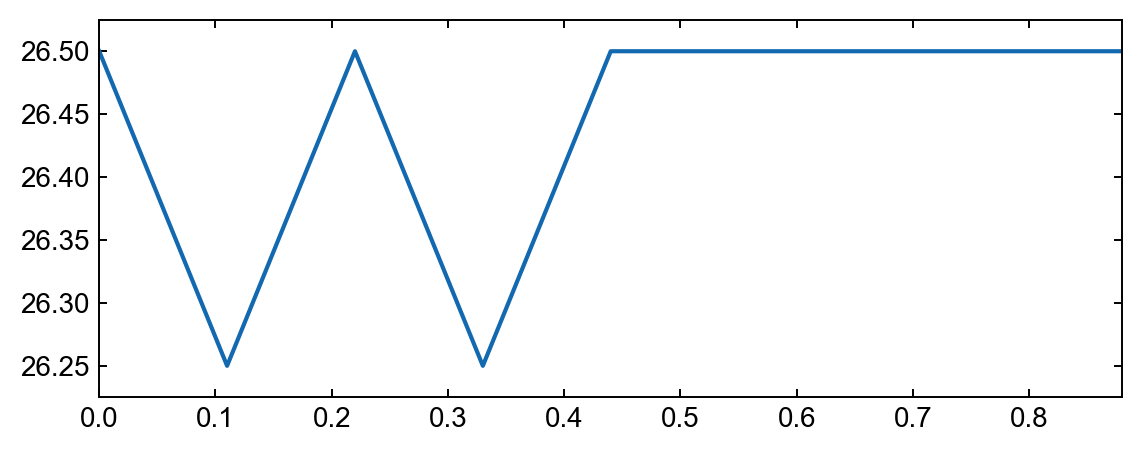

In [16]:
for i, scatter in enumerate(fig.data):
    with plt.style.context(["sp-paper"]):
        mfig, ax = plt.subplots(figsize = (3.3*2, 2.5))
        ax.plot(np.array(scatter.x, dtype=float), np.array(scatter.y, dtype=float))
        ax.autoscale(tight=True)
        ax.margins(y=0.1)